In [128]:
import utils
import datetime
import pandas as pd
import instrument
import plotly.graph_objects as go
import matplotlib.pyplot as plt

BUY = 1
SELL = -1

RISK_REWARD_RATIO = 2.0
RISKED_PIPS = 15.0

In [59]:
def create_candle_plot(df_plot, range=None, start=None):
    fig = go.Figure()
    fig.add_trace(go.Candlestick(
        x=df_plot.time, open=df_plot.mid_o, high=df_plot.mid_h, low=df_plot.mid_l, close=df_plot.mid_c,
        line=dict(width=1), opacity=1,
        increasing_fillcolor='#24A06B',
        decreasing_fillcolor="#CC2E3C",
        increasing_line_color='#2EC886',  
        decreasing_line_color='#FF3A4C'
    ))
    if range is not None:
        delta = range[1] - range[0]
        fig.add_hline(y=range[0], line_width=2, line_dash="dash", line_color="yellow")
        fig.add_hline(y=range[1], line_width=2, line_dash="dash", line_color="yellow")
        
    if start is not None:
        fig.add_vline(x=start, line_width=2, line_dash="dash", line_color="blue")
    
    fig.update_layout(width=1000,height=300,
        margin=dict(l=10,r=10,b=10,t=10),
        font=dict(size=10,color="#e1e1e1"),
        paper_bgcolor="#1e1e1e",
        plot_bgcolor="#1e1e1e")
    fig.update_xaxes(
        gridcolor="#1f292f",
        showgrid=True,fixedrange=True,rangeslider=dict(visible=False)
    )
    fig.update_yaxes(
        gridcolor="#1f292f",
        showgrid=True
    )
    fig.show()
    
def plot_true_false_counts(dataframe, column_name):
    """
    Plot a bar chart showing the number of True and False entries in a specified column of a pandas DataFrame.

    Parameters:
    - dataframe: pandas DataFrame
        The DataFrame containing the data.
    - column_name: str
        The name of the column for which the True and False counts are to be plotted.

    Returns:
    None (displays the plot)
    """
    # Check if the specified column exists in the DataFrame
    if column_name not in dataframe.columns:
        print(f"Error: Column '{column_name}' not found in the DataFrame.")
        return

    # Count the occurrences of True and False in the specified column
    value_counts = dataframe[column_name].value_counts()

    # Plotting the bar chart with labels on the x-axis
    plt.bar(['False', 'True'], value_counts.values, color=['red', 'green'])
    
    # Adding labels and title
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(f"True/False Counts in {column_name}")

    # Display the plot
    plt.show()

In [117]:
def get_date_as_string(df):
    return df.loc[(len(df.index) - 1), "time"].strftime("%Y-%m-%d")

def get_price_data(pairname, granularity):
    df = pd.read_pickle(utils.get_his_data_filename(pairname, granularity))
    non_cols = ["time", "volume"]
    mod_cols = [x for x in df.columns if x not in non_cols]
    df[mod_cols] = df[mod_cols].apply(pd.to_numeric)
    return df[["time", "mid_o", "mid_h", "mid_l", "mid_c"]]

def get_day_data(date, price_data):
    start_time = date - datetime.timedelta(hours=2)
    end_time = date + datetime.timedelta(days=1)
    df_day = price_data[
        (price_data.time >= start_time) & (price_data.time < end_time)
    ].copy()
    df_day.dropna(inplace=True)
    df_day.reset_index(drop=True, inplace=True)
    return df_day

def get_post_london_open_data(df):
    day = get_date_as_string(df)
    london_start_time = utils.get_utc_dt_from_string(f"{day} 07:00:00+00:00")
    df_post_london_open = df[(df.time >= london_start_time)].copy()
    df_post_london_open.reset_index(drop=True, inplace=True)
    return df_post_london_open

def calculate_london_start_time(day):
    return utils.get_utc_dt_from_string(f"{day} 07:00:00+00:00")

def calculate_tokyo_start_time(day):
    return utils.get_utc_dt_from_string(f"{day} 00:00:00+00:00")

def calculate_pre_open_range(df_day):
    date = utils.get_utc_dt_from_string(get_date_as_string(df_day))
    tokyo_open_time = calculate_tokyo_start_time(date)
    london_open_time = calculate_london_start_time(date)
    df_pre_open = df_day[(df_day.time < (london_open_time))].copy()
    range_max = max(df_pre_open.mid_h.max(), df_pre_open.mid_l.max())
    range_min = min(df_pre_open.mid_h.min(), df_pre_open.mid_l.min())
    return range_min, range_max

def calculate_take_profit(position_type, entry_price):
    delta = 0.0015*RISK_REWARD_RATIO
    if position_type == BUY:
        take_profit = entry_price + delta
    elif position_type == SELL:
        take_profit = entry_price - delta
    return take_profit    

def calculate_stop_loss(position_type, entry_price):
    delta = 0.0015
    if position_type == BUY:
        stop_loss = entry_price - delta
    elif position_type == SELL:
        stop_loss = entry_price + delta
    return stop_loss

In [108]:
def get_close_time_as_string(df):
    close_time = df.loc[(len(df.index) - 1), "time"].strftime("%H:%M:%S")
    return close_time

def exit_time(df):
    return utils.get_utc_dt_from_string(
        f"{get_date_as_string(df)} {get_close_time_as_string(df)}"
    )

def get_past_data(df, index):
    return df.iloc[:index].copy()

def count_open_trades(df):
    buy_list = [x for x in df.IS_TRADE if x == BUY]
    sell_list = [x for x in df.IS_TRADE if x == SELL]
    buys = len(buy_list)
    sells = len(sell_list)
    return {"total": (buys + sells), "buys": buys, "sells": sells}

def over_range_max(row, range_max):
    return row.mid_c > range_max

def under_range_min(row, range_min):
    return row.mid_c < range_min

def over_take_profit(row, take_profit):
    return row.mid_h > take_profit

def over_stop_loss(row, stop_loss):
    return row.mid_h > stop_loss

def under_take_profit(row, take_profit):
    return row.mid_l < take_profit

def under_stop_loss(row, stop_loss):
    return row.mid_l < stop_loss

def calculate_trades(df, range_min, range_max):
    df["IS_TRADE"] = 0
    for index, row in df.iterrows():
        trade_count = count_open_trades(get_past_data(df, index + 10))
        if trade_count["total"] == 0:
            if over_range_max(row, range_max):
                # Trade entered on the next candle
                df.loc[index + 1, "IS_TRADE"] = BUY
                entry_price = df.loc[index + 1, "mid_o"]
            elif under_range_min(row, range_min):
                # Trade entered on the next candle 
                df.loc[index + 1, "IS_TRADE"] = SELL
                entry_price = df.loc[index + 1, "mid_o"]
        elif trade_count["total"] == 1:
            if trade_count["buys"] == 1:
                if over_take_profit(row, calculate_take_profit(BUY, entry_price)):
                    df.loc[index, "IS_TRADE"] = SELL
                    df.loc[index, "RESULT"] = "WIN"
                elif under_stop_loss(row, calculate_stop_loss(BUY, entry_price)):
                    df.loc[index, "IS_TRADE"] = SELL
                    df.loc[index, "RESULT"] = "LOSS"
            elif trade_count["sells"] == 1:
                if under_take_profit(row, calculate_take_profit(SELL, entry_price)):
                    df.loc[index, "IS_TRADE"] = BUY
                    df.loc[index, "RESULT"] = "WIN"
                elif over_stop_loss(row, calculate_stop_loss(SELL, entry_price)):
                    df.loc[index, "IS_TRADE"] = BUY
                    df.loc[index, "RESULT"] = "LOSS"
        if row.time >= exit_time(df) and trade_count['total'] == 1:
            if trade_count["buys"] == 1:
                df.loc[index, "IS_TRADE"] = SELL
                if df.loc[index, "mid_c"] < entry_price:
                    df.loc[index, "RESULT"] = "LOSS"
                else:
                    df.loc[index, "RESULT"] = "WIN"
            if trade_count["sells"] == 1:
                df.loc[index, "IS_TRADE"] = BUY
                if df.loc[index, "mid_c"] > entry_price:
                    df.loc[index, "RESULT"] = "LOSS"
                else:
                    df.loc[index, "RESULT"] = "WIN"
    return df

def process_trades(df, i_pair):
# Filter data to only keep rows containing trades
    df_trades = df[df.IS_TRADE != 0].copy()
    df_trades.reset_index(drop=True, inplace=True)

    if len(df_trades) > 0:
        
        # Compute entry price
        entry_price = df_trades.loc[0]["mid_o"]
        
        # Process SELL trade
        if df_trades.loc[0].IS_TRADE == -1:
            # Compute profit
            if df_trades.loc[1].RESULT == "WIN":
                df_trades.loc[1, "GAIN"] = (entry_price - calculate_take_profit(SELL, entry_price)) / i_pair.pipLocation
            # Compute loss
            if df_trades.loc[1].RESULT == "LOSS":
                df_trades.loc[1, "GAIN"] = (entry_price - calculate_stop_loss(SELL, entry_price)) / i_pair.pipLocation
        # Porocess BUY trade
        if df_trades.loc[0].IS_TRADE == 1:
            # Compute profit
            if df_trades.loc[1].RESULT == "WIN":
                df_trades["GAIN"] = (calculate_take_profit(BUY, entry_price) - entry_price) / i_pair.pipLocation
            # Compute loss
            if df_trades.loc[1].RESULT == "LOSS":
                df_trades["GAIN"] = (calculate_stop_loss(BUY, entry_price) - entry_price) / i_pair.pipLocation
                
    else:
        return []
                
    return df_trades

In [101]:
granularity = "M5"
date = "2022-10-21"
pairname = 'GBP_USD'

# Get price data, pair instrument and date object
price_data = get_price_data(pairname, granularity)
i_pair = instrument.Instrument.get_instruments_dict()[pairname]
date = utils.get_utc_dt_from_string(date)

# Trim price data to the day being tested
df = get_day_data(date, price_data)

# Calculate the range  
range_min, range_max = calculate_pre_open_range(df)
print(range_max, range_min)

# Reset the index in the price data
df.reset_index(drop=True, inplace=True)

df = calculate_trades(df, range_min, range_max)
#df_trades = process_trades(df, i_pair)
create_candle_plot(df, range=(range_min, range_max), start=calculate_london_start_time(date))


1.12378 1.11752


In [102]:
df_trades = df[df.IS_TRADE != 0].copy()
print(df_trades)

                         time    mid_o    mid_h    mid_l    mid_c  IS_TRADE  \
122 2022-10-21 08:10:00+00:00  1.11678  1.11718  1.11630  1.11630        -1   
124 2022-10-21 08:20:00+00:00  1.11580  1.11582  1.11482  1.11556         1   

    RESULT  
122    NaN  
124    WIN  


In [124]:
def test_trade(pairname, granularity, date):
    # Get price data, pair instrument and date object
    price_data = get_price_data(pairname, granularity)
    i_pair = instrument.Instrument.get_instruments_dict()[pairname]
    # Trim price data to the day being tested
    df = get_day_data(date, price_data)
    # Calculate the range  
    range_min, range_max = calculate_pre_open_range(df)
    # Reset the index in the price data
    df.reset_index(drop=True, inplace=True)
    df = calculate_trades(df, range_min, range_max)
    df_trades = process_trades(df, i_pair)
    return df_trades

def run_pair(start_date, end_date, pairname, granularity):
    start_date = utils.get_utc_dt_from_string(start_date)
    end_date = utils.get_utc_dt_from_string(end_date)
    day_count = (end_date - start_date).days - 1
    days = []
    results = []
    for date in (start_date + datetime.timedelta(n) for n in range(day_count)):
        days.append(date)
        df = get_day_data(date, price_data) 
        if df.empty:
            results.append(0.0)
        else:
            df_trades = test_trade(pairname, granularity, date)
            if len(df_trades) == 2:
                gain = round(df_trades["GAIN"].iloc[-1], 5)
            elif len(df_trades) == 0:
                gain = 0
            results.append(gain)
    df_results = pd.DataFrame({"date": days, "pips": results})
    df_results["gain"] = df_results.pips.cumsum()
    return df_results

granularity = "M5"
start_date = "2018-01-02"
end_date = "2023-01-02"

pairs = ['GBP_USD']

fig = go.Figure()
for pairname in pairs:
    df_results = run_pair(start_date, end_date, pairname, granularity)
    fig.add_trace(
        go.Scatter(
            x=df_results.date,
            y=df_results.gain,
            line=dict(width=2),
            line_shape="linear",
            name=pairname,
        )
    )
fig.show()

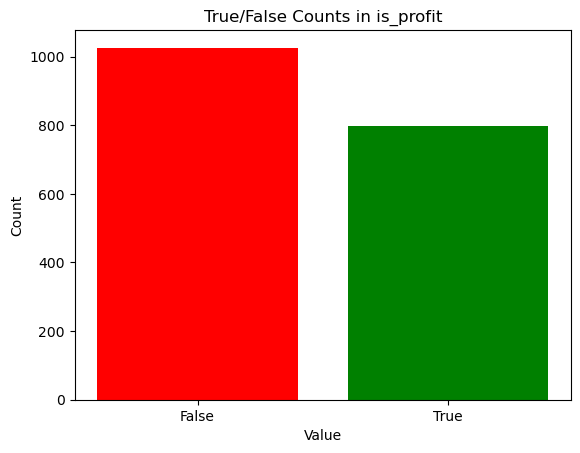

In [129]:
df_results["is_profit"] = df_results["pips"] >= 0.0
plot_true_false_counts(df_results, "is_profit")